In [1]:
from applications import APPLICATIONS
from goodput import _predict_accum_time, _predict_log_optim_time, _predict_network_time, fit_perf_params
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

In [2]:
cluster_name="aws"
app_name="deepspeech2"
output_scalability_csv = os.path.join("../traces/", app_name, f"scalability-e{cluster_name}.csv")
output_placements_csv = os.path.join("../traces/", app_name, f"placements-e{cluster_name}.csv")

In [3]:
app = APPLICATIONS[cluster_name][app_name]

In [4]:
df = app.scalability
num_nodes = df.num_nodes.to_numpy()
num_replicas = df.num_replicas.to_numpy()
local_bsz = df.local_bsz.to_numpy()
sync_time = df.sync_time.to_numpy()
compute_time = (df.step_time - df.sync_time).to_numpy()
step_time = df.step_time.to_numpy()

perf_params = fit_perf_params(num_nodes, num_replicas, local_bsz, compute_time, step_time)

In [5]:
def predict_step_sync_time(perf_params, num_nodes, num_replicas, local_bsz):
  pred_compute_time = _predict_accum_time(perf_params, local_bsz)
  pred_network = _predict_network_time(perf_params, num_nodes, num_replicas)
  pred_step_time = np.exp(_predict_log_optim_time(perf_params, pred_compute_time, pred_network))
  pred_sync_time = pred_step_time - pred_compute_time
  return pred_step_time, pred_sync_time

In [6]:
pred_step_time, pred_sync_time = predict_step_sync_time(perf_params, num_nodes, num_replicas, local_bsz)
pred_step_error = np.abs(pred_step_time - step_time) / step_time
print(f"step_time prediction: mean prediction error : {np.mean(pred_step_error)*100}%, variance: {np.std(pred_step_error)*100}%")

pred_sync_error = np.abs(pred_sync_time - sync_time) / sync_time
print(f"sync_time prediction: mean prediction error : {np.mean(pred_sync_error)*100}%, variance: {np.std(pred_sync_error)*100}%")

step_time prediction: mean prediction error : 7.39724578868789%, variance: 5.9198045707083775%
sync_time prediction: mean prediction error : 25.278804316227333%, variance: 24.476013052819333%


In [7]:
start_num_nodes, end_num_nodes = 2, 16
start_num_replicas, end_num_replicas = 2, 128
col_names = df.columns
output_df = pd.DataFrame(columns=col_names)
ngpus_per_node = 8
local_bsz = list(df.local_bsz.unique())

# generate num_nodes, num_replicas
new_num_nodes, new_num_replicas, new_local_bsz = [] , [], []
for nnodes in range(start_num_nodes, end_num_nodes + 1):
  config_ngpus = []
  ngpus = nnodes * 1
  while ngpus < nnodes * ngpus_per_node + 1:
    new_num_nodes.extend([nnodes] * len(local_bsz))
    new_num_replicas.extend([ngpus] * len(local_bsz))
    new_local_bsz.extend(local_bsz)
    ngpus += 4
new_num_nodes = np.asarray(new_num_nodes)
new_num_replicas = np.asarray(new_num_replicas)
new_local_bsz = np.asarray(new_local_bsz)
print(new_num_nodes.shape)
print(new_num_replicas.shape)
print(new_local_bsz.shape)


(1722,)
(1722,)
(1722,)


In [8]:
# populate output_df
pred_step_time, pred_sync_time = predict_step_sync_time(perf_params, new_num_nodes, new_num_replicas, new_local_bsz)
output_dict = {
  "local_bsz" : new_local_bsz,
  "num_nodes" : new_num_nodes,
  "num_replicas" : new_num_replicas,
  "step_time" : pred_step_time,
  "sync_time" : pred_sync_time
}
output_df = pd.DataFrame(output_dict)
output_df.to_csv(output_scalability_csv, index=False)
app.placements.to_csv(output_placements_csv, index=False)

In [9]:
def get_performance_profiles(cluster_name, app_name, selector_bsize=None):
  app = APPLICATIONS[cluster_name][app_name]
  df = app.scalability
  num_nodes = df.num_nodes.to_numpy()
  num_replicas = df.num_replicas.to_numpy()
  local_bsz = df.local_bsz.to_numpy()
  sync_time = df.sync_time.to_numpy()
  step_time = df.step_time.to_numpy()
  # include placements.csv too
  df = app.placements
  def sum_digits(val):
    return sum([int(v) for v in str(val)])
  def num_digits(val):
    return len(str(val))
  p_num_nodes = np.vectorize(num_digits)(df.placement.to_numpy())
  p_num_replicas = np.vectorize(sum_digits)(df.placement.to_numpy())
  p_step_time = df.step_time.to_numpy()
  p_local_bsz = df.local_bsz.to_numpy()
  p_sync_time = df.sync_time.to_numpy()
  
  if True:
    num_nodes = np.hstack((num_nodes, p_num_nodes))
    num_replicas = np.hstack((num_replicas, p_num_replicas))
    local_bsz = np.hstack((local_bsz, p_local_bsz))
    step_time = np.hstack((step_time, p_step_time))
    sync_time = np.hstack((sync_time, p_sync_time))

  if selector_bsize is not None:
    selector_vec = (local_bsz == selector_bsize)
    num_nodes = num_nodes[selector_vec]
    num_replicas = num_replicas[selector_vec]
    local_bsz = local_bsz[selector_vec]
    sync_time = sync_time[selector_vec]
    step_time = step_time[selector_vec]
  return num_nodes, num_replicas, local_bsz, step_time, sync_time

def build_xput_model(num_nodes, num_replicas, atomic_bsz, step_time, sync_time):
  compute_time = step_time - sync_time
  perf_params = fit_perf_params(num_nodes, num_replicas, atomic_bsz, compute_time, step_time)
  return perf_params

def predict_xput_model(perf_params, num_nodes, num_replicas, atomic_bsz):
  pred_t_grad = _predict_accum_time(perf_params, atomic_bsz)
  pred_t_sync = _predict_network_time(perf_params, num_nodes, num_replicas)
  pred_log_t_iter = _predict_log_optim_time(perf_params, pred_t_grad, pred_t_sync)
  pred_t_iter = np.exp(pred_log_t_iter)
  return pred_t_iter, pred_t_sync

In [10]:
cluster_name, app_name = "rtx", "deepspeech2"
selector_bsize = None
num_nodes, num_replicas, local_bsz, step_time, sync_time = get_performance_profiles(cluster_name, app_name, selector_bsize)
app_perf_params = build_xput_model(num_nodes, num_replicas, local_bsz, step_time, sync_time)
pred_step_time, pred_sync_time = predict_xput_model(app_perf_params, num_nodes, num_replicas, local_bsz)
pred_xput, xput = local_bsz / pred_step_time, local_bsz / step_time

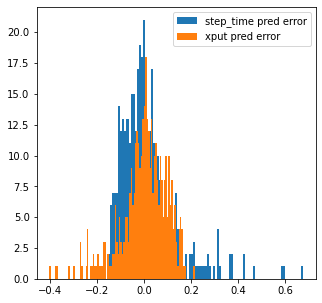

In [11]:
# compute error
error_step_time, error_xput = (pred_step_time - step_time) / step_time, (pred_xput - xput) / xput
plt.hist(error_step_time, bins=100)
plt.hist(error_xput, bins=100)
plt.legend(['step_time pred error', 'xput pred error'])

In [12]:
def plot_single_config(cluster_name, app_name, pred_num_nodes, pred_num_replicas, atomic_bsz, output_figpath):
  app = APPLICATIONS[cluster_name][app_name]
  sc_df = app.scalability
  pl_df = app.placements
  pred_local_bsz = np.asarray([atomic_bsz] * len(pred_num_nodes))

  num_nodes, num_replicas, local_bsz, step_time, sync_time = get_performance_profiles(cluster_name, app_name, selector_bsize)
  app_perf_params = build_xput_model(num_nodes, num_replicas, local_bsz, step_time, sync_time)

  max_num_nodes, max_num_replicas = np.max(num_nodes), np.max(num_replicas)
  pred_num_nodes = pred_num_nodes[pred_num_nodes <= max_num_nodes]
  pred_num_replicas = pred_num_replicas[pred_num_replicas <= max_num_replicas]

  def lookup_placement(num_nodes, num_replicas, local_bsz):
    num_replicas_per_node = int(num_replicas / num_nodes)
    placement_id = int("".join([str(num_replicas_per_node)]*num_nodes))
    entry = pl_df.query(f'placement == {placement_id} & local_bsz == {local_bsz}')
    # print(f"Looking up placement: {placement_id}, entry={entry}")
    if entry.empty:
      return None
    else:
      return entry.step_time.item(), entry.sync_time.item()

  def lookup_scalability(num_nodes, num_replicas, local_bsz):
    entry = sc_df.query(f'num_nodes == {num_nodes} & num_replicas == {num_replicas} & local_bsz == {local_bsz}')
    if entry.empty:
      return None
    else:
      return entry.step_time.item(), entry.sync_time.item()

  actual_sync_time, actual_step_time = [], []
  for nnodes, nreplicas in zip(pred_num_nodes, pred_num_replicas):
    ret = lookup_scalability(nnodes, nreplicas, atomic_bsz)
    if ret is None:
      ret = lookup_placement(nnodes, nreplicas, atomic_bsz)
    if ret is not None:
      step_time, sync_time = ret
    else:
      print(f"missing {nnodes}, {nreplicas}")
      step_time, sync_time = 0, 0
    actual_step_time.append(step_time)
    actual_sync_time.append(sync_time)

  actual_sync_time, actual_step_time = np.asarray(actual_sync_time), np.asarray(actual_step_time)

  pred_step_time, pred_sync_time = predict_xput_model(app_perf_params, pred_num_nodes, pred_num_replicas, pred_local_bsz)
  pred_xput, actual_xput = pred_local_bsz / pred_step_time, pred_local_bsz / actual_step_time
  plt.semilogx(pred_num_replicas, pred_step_time, 'r', label='Model', linewidth=3, markersize=12)
  plt.semilogx(pred_num_replicas, actual_step_time, 'X', label='Actual', markersize=12)
  max_val = max(np.max(pred_step_time), np.max(actual_step_time))
  plt.ylim([0, max_val*1.1])
  plt.xlabel('Num GPUs')
  plt.xticks(pred_num_replicas, pred_num_replicas)
  plt.title(f"{app_name} on {cluster_name}: bsz={atomic_bsz}")
  plt.legend()
  plt.ylabel('Step time (s)')
  plt.savefig(output_figpath, bbox_inches='tight')
  plt.clf()

  def get_error(x, y):
    return np.abs(x - y) / y
  step_error = get_error(pred_step_time,actual_step_time)
  xput_error = get_error(pred_xput,actual_xput)
  print(f"\tmax step_time prediction error: {np.max(step_error)*100}%, avg={np.mean(step_error)*100}%")
  print(f"\tmax xput prediction error: {np.max(xput_error)*100}%, avg={np.mean(xput_error)*100}%")

In [13]:
cluster_configs = {}
cluster_configs["rtx"] = (np.asarray([1, 1, 1, 2, 2, 3]), np.asarray([1, 2, 4, 8, 16, 24]))
cluster_configs["dgx"] = (np.asarray([1, 1, 1, 2, 2]), np.asarray([1, 2, 4, 8, 16]))
cluster_configs["aws"] = (np.asarray([1, 1, 2, 2, 4, 8, 16]), np.asarray([1, 2, 4, 8, 16, 32, 64]))
batch_sizes = {
  "cifar10" : 64,
  "bert" : 12,
  "deepspeech2" : 10,
  "yolov3" : 8,
  "imagenet" : 81
}
for app_name in ["cifar10", "bert", "deepspeech2", "yolov3", "imagenet"]:
  output_dir="../figs/tmp"
  for cluster_name, cluster_config in cluster_configs.items():
    pred_num_nodes, pred_num_replicas = cluster_config
    atomic_bsz = batch_sizes[app_name]
    print(f"{app_name} on {cluster_name}, bsz={atomic_bsz}")
    output_fig_name = os.path.join(output_dir, f"{app_name}_{cluster_name}.png")
    plot_single_config(cluster_name, app_name, pred_num_nodes, pred_num_replicas, atomic_bsz, output_fig_name)

cifar10 on rtx, bsz=64
	max step_time prediction error: 12.500258946807552%, avg=6.026649018389286%
	max xput prediction error: 14.286052502953616%, avg=6.073130770224906%
cifar10 on dgx, bsz=64
	max step_time prediction error: 16.010193582670738%, avg=5.864178603538306%
	max xput prediction error: 19.062067488427285%, avg=6.3565042755761345%
cifar10 on aws, bsz=64
	max step_time prediction error: 19.13068460105479%, avg=10.537823400790595%
	max xput prediction error: 23.656295971691023%, avg=11.9380174231655%
bert on rtx, bsz=12
	max step_time prediction error: 12.577304707369564%, avg=8.992684964700077%
	max xput prediction error: 12.136897115899488%, avg=8.69277378132376%
bert on dgx, bsz=12
	max step_time prediction error: 7.599504923224029%, avg=2.5169568017716757%
	max xput prediction error: 8.22452836092444%, avg=2.6551577126312167%
bert on aws, bsz=12
	max step_time prediction error: 32.53994599759303%, avg=10.539703312932081%
	max xput prediction error: 48.23587303448051%, avg

<Figure size 360x360 with 0 Axes>

In [14]:
figname="../figs/tmp/yolov3_rtx_8"
pred_num_nodes, pred_num_replicas = cluster_configs["rtx"]
atomic_bsz = batch_sizes["yolov3"]
plot_single_config("rtx", "yolov3", pred_num_nodes, pred_num_replicas, 8, figname)

	max step_time prediction error: 19.40936396027066%, avg=8.304404026969534%
	max xput prediction error: 24.08389474765068%, avg=8.667466548805585%


<Figure size 360x360 with 0 Axes>

In [15]:
def eval_extrapolation(cluster_name, app_name, limit_nodes, limit_replicas, eval_nodes, eval_replicas, eval_bsz):
  num_nodes, num_replicas, local_bsz, step_time, sync_time = get_performance_profiles(cluster_name, app_name)
  selector = (num_nodes <= limit_nodes) & (num_replicas <= limit_replicas)
  fit_vals = (num_nodes[selector], num_replicas[selector], local_bsz[selector], step_time[selector], sync_time[selector])

  app = APPLICATIONS[cluster_name][app_name]
  sc_df = app.scalability
  pl_df = app.placements
  
  def lookup_placement(num_nodes, num_replicas, local_bsz):
    num_replicas_per_node = int(num_replicas / num_nodes)
    placement_id = int("".join([str(num_replicas_per_node)]*num_nodes))
    entry = pl_df.query(f'placement == {placement_id} & local_bsz == {local_bsz}')
    # print(f"Looking up placement: {placement_id}, entry={entry}")
    if entry.empty:
      return None
    else:
      return entry.step_time.item(), entry.sync_time.item()

  def lookup_scalability(num_nodes, num_replicas, local_bsz):
    entry = sc_df.query(f'num_nodes == {num_nodes} & num_replicas == {num_replicas} & local_bsz == {local_bsz}')
    if entry.empty:
      return None
    else:
      return entry.step_time.item(), entry.sync_time.item()

  # lookup eval configs for step_time, sync_time
  actual_step_time, actual_sync_time = [], []
  for nodes, replicas, bsz in zip(eval_nodes, eval_replicas, eval_bsz):
    ret = lookup_scalability(nodes, replicas, bsz)
    if ret is None:
      ret = lookup_placement(nodes, replicas, bsz)
    if ret is not None:
      step_time, sync_time = ret
    else:
      print(f"missing {nodes}, {replicas}")
      step_time, sync_time = 0, 0
    actual_step_time.append(step_time)
    actual_sync_time.append(sync_time)
  actual_sync_time, actual_step_time = np.asarray(actual_sync_time), np.asarray(actual_step_time)

  test_vals = (eval_nodes, eval_replicas, eval_bsz, actual_step_time, actual_sync_time)

  # build xput model on fit_vals
  app_perf_params = build_xput_model(*fit_vals)

  # predict step_time and sync time on test_vals
  pred_step_time, pred_sync_time = predict_xput_model(app_perf_params, test_vals[0], test_vals[1], test_vals[2])

  # compute errors
  def compute_relative_error(x, y):
    return (x - y) / y
  pred_step_error, pred_sync_error = compute_relative_error(pred_step_time, test_vals[3]), compute_relative_error(pred_sync_time, test_vals[4])
  
  return pred_step_error


In [20]:
limit_nodes, limit_replicas = [3, 4, 16], [12, 8, 64]
cluster_name = "aws"
fig_prefix = "../figs/tmp/extrap-aws-"
cluster_nnodes, cluster_nreplicas = cluster_configs[cluster_name]
for app_name in ["imagenet", "bert", "cifar10", "deepspeech2", "yolov3"]:
  print(f"Eval: {app_name}")
  local_bsz = np.asarray([batch_sizes[app_name]]*len(cluster_nnodes))
  for limit_node, limit_replica in zip(limit_nodes, limit_replicas):
    step_error = eval_extrapolation(cluster_name, app_name, limit_node, limit_replica, cluster_nnodes, cluster_nreplicas, local_bsz)
    plt.semilogx(cluster_nreplicas, 100*step_error, label=f"n={limit_node}, r={limit_replica}")
  plt.title(f"Step-time prediction error, model={app_name}")
  plt.ylabel("relative error(%)")
  plt.xlabel("num replicas")
  plt.legend()
  plt.ylim([-50, 50])
  plt.axhline(y=0, linewidth=0.8)
  plt.xticks(cluster_nreplicas, cluster_nreplicas)
  plt.savefig(f"{fig_prefix}{app_name}.png")
  plt.clf()

Eval: imagenet
Eval: bert
Eval: cifar10
Eval: deepspeech2
Eval: yolov3


<Figure size 360x360 with 0 Axes>